In [1]:
import geemap
import ee
from Monarch import user_gee
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
from matplotlib import rcParams
import os

In [2]:
os.chdir(r"D:\Data\parper\data")

In [3]:
Map = geemap.Map()
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [4]:
shp = geemap.shp_to_ee('shp/JX.shp')
roi = shp.geometry()
Map.center_object(roi, 8)
Map.addLayer(roi, {}, 'roi')

In [5]:
points = geemap.shp_to_ee('shp/landuse_point.shp')

Map.addLayer(points, {'color': 'FF0000'}, 'points')

In [10]:
label = 'TDLYDM'
def sample_points_to_df(img, ps, col_names=None):
    ps_data = img.sampleRegions(ps,
                                properties = [label],
                                geometries=True, 
                                scale=10)
    values_list = [f['properties'] for f in ps_data.getInfo()["features"]]
    if col_names == None:
        values_df = pd.DataFrame(values_list)
    else:
        values_df = pd.DataFrame(values_list)[col_names]
    return values_df

In [43]:
from Monarch import user_gee
year = 2018
s2_year = []
lswis = []
ndvis = []
evis = []
for i in range(2, 11):
    s2 = ee.ImageCollection("COPERNICUS/S2")\
            .filterBounds(roi)\
            .sort('CLOUD_COVERAGE_ASSESSMENT', False)\
            .filterDate(str(year), str(year+1))\
            .filter(ee.Filter.calendarRange(i, i, 'month'))
    s2_rm_cloud = s2.map(user_gee.rm_cloud_s2_sr)
    s2_z = s2_rm_cloud.merge(s2).mosaic().select(['B2', 'B3', 'B4', 'B5', 'B8', 'B11'])
    a = s2.aggregate_array('system:time_start').map(lambda i: ee.Date(i).format('YYYY-MM-dd'))
    evi = s2_z.expression(
        '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
        'NIR': s2_z.select('B8'),
        'RED': s2_z.select('B4'),
        'BLUE': s2_z.select('B2')
    }).rename("S2_EVI")
    ndvi = s2_z.normalizedDifference(['B8', 'B4']).rename("S2_NDVI")
    lswi = s2_z.normalizedDifference(['B8', 'B11']).rename("S2_LSWI")
    ndvis.append(ndvi)
    lswis.append(lswi)
    evis.append(evi)
    s2_image = s2_z.addBands(ndvi)
    s2_image = s2_image.addBands(lswi)
    s2_image = s2_image.addBands(evi)
    s2_year.append(s2_image)

In [7]:
config = {
    "font.family": 'serif',
    "font.size": 14,
    "mathtext.fontset": 'stix',
    "font.serif": 'Simsun',
}
rcParams.update(config)

In [46]:
lswi = ee.ImageCollection(lswis).toBands().clip(roi)
ndvi = ee.ImageCollection(ndvis).toBands().clip(roi)
evi = ee.ImageCollection(evis).toBands().clip(roi)

In [47]:
lswi_df = sample_points_to_df(lswi, points.filter(ee.Filter.lt('CID', 100)))
ndvi_df = sample_points_to_df(ndvi, points.filter(ee.Filter.lt('CID', 100)))
evi_df = sample_points_to_df(evi, points.filter(ee.Filter.lt('CID', 100)))

In [48]:
evi_df

,0_S2_EVI,10_S2_EVI,11_S2_EVI,1_S2_EVI,2_S2_EVI,3_S2_EVI,4_S2_EVI,5_S2_EVI,6_S2_EVI,7_S2_EVI,8_S2_EVI,9_S2_EVI,TDLYDM
0,-0.962576,-0.887550,-0.998165,-1.141766,-1.593539,-1.688563,-0.317113,-3.314582,-2.962167,-1.997830,-0.964348,-2.020677,1
1,-0.288247,-11.777950,-0.049602,4.666667,-5.395814,-14.942085,19.545455,-1.777379,-17.209857,-1.976744,4.945568,13.397098,1
2,-0.832047,-0.990539,-0.803723,-0.657993,-0.962409,-1.272011,0.372279,-2.457879,3.118812,-8.276923,9.514388,-1.811395,1
3,-0.249194,0.558282,0.139247,0.359008,0.976440,5.325132,0.210387,8.266129,0.512949,0.671290,0.072473,0.217946,1
4,0.579504,-28.741007,0.591409,-1.525271,0.465080,0.696603,-1.049405,-2.746311,0.495741,0.868334,0.741568,0.585345,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,0.877625,0.604811,0.205429,0.315688,0.362438,0.940386,0.249307,0.187067,0.179594,0.065047,0.264141,0.696152,6
594,-0.781544,-0.440695,-2.235401,-0.784447,-1.531223,-1.742152,1.013851,-20.842349,-1.248969,-2.719547,-2.975391,-4.297189,6
595,0.122235,0.183659,0.179047,0.114322,0.111819,0.097904,0.047156,0.166254,0.146180,0.094850,0.149889,0.183936,6
596,0.128648,0.181699,0.053198,0.108108,0.118630,0.218484,-0.220487,0.187434,0.190507,0.036972,0.119974,0.190756,6


In [96]:
lswi_mean = lswi_df.groupby('TDLYDM').mean()[[f'{i}_S2_LSWI' for i in range(12)]]
ndvi_mean = ndvi_df.groupby('TDLYDM').mean()[[f'{i}_S2_NDVI' for i in range(12)]]
evi_mean = evi_df.groupby('TDLYDM').mean()[[f'{i}_S2_EVI' for i in range(12)]]

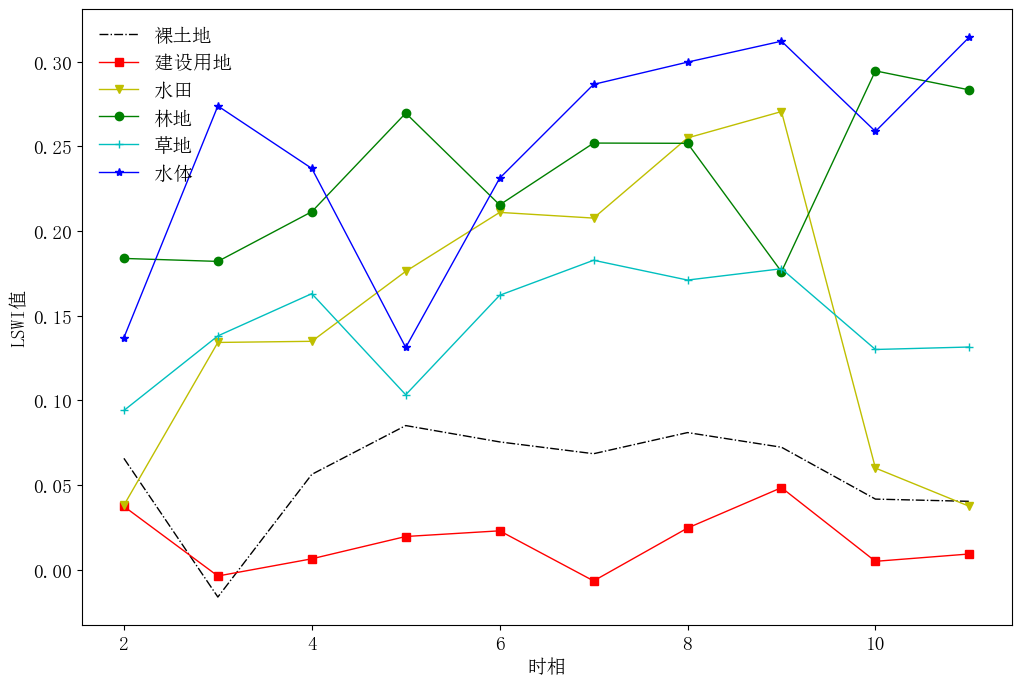

In [98]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlabel('时相')
ax.set_ylabel('LSWI值')
# ax.plot([i for i in range(365)], lswi_mean.values, '-o', color='blue', lw=1, label='LSWI')
line_type = ['-.', '-s', '-v', '-o', '-+', '-*']
line_color = ['k', 'r', 'y', 'g', 'c', 'b']
lable = ['裸土地', '建设用地', '水田', '林地', '草地', '水体']
for i in range(6):
    ax.plot(list(range(2, 12)), lswi_mean.loc[i+1].values[1:11], line_type[i], color=line_color[i], lw=1, label=lable[i])
ax.legend(loc=2, frameon=False, handlelength=2)
fig.savefig(f'png_data/LSWI_mean.png', dpi=600, bbox_inches='tight')

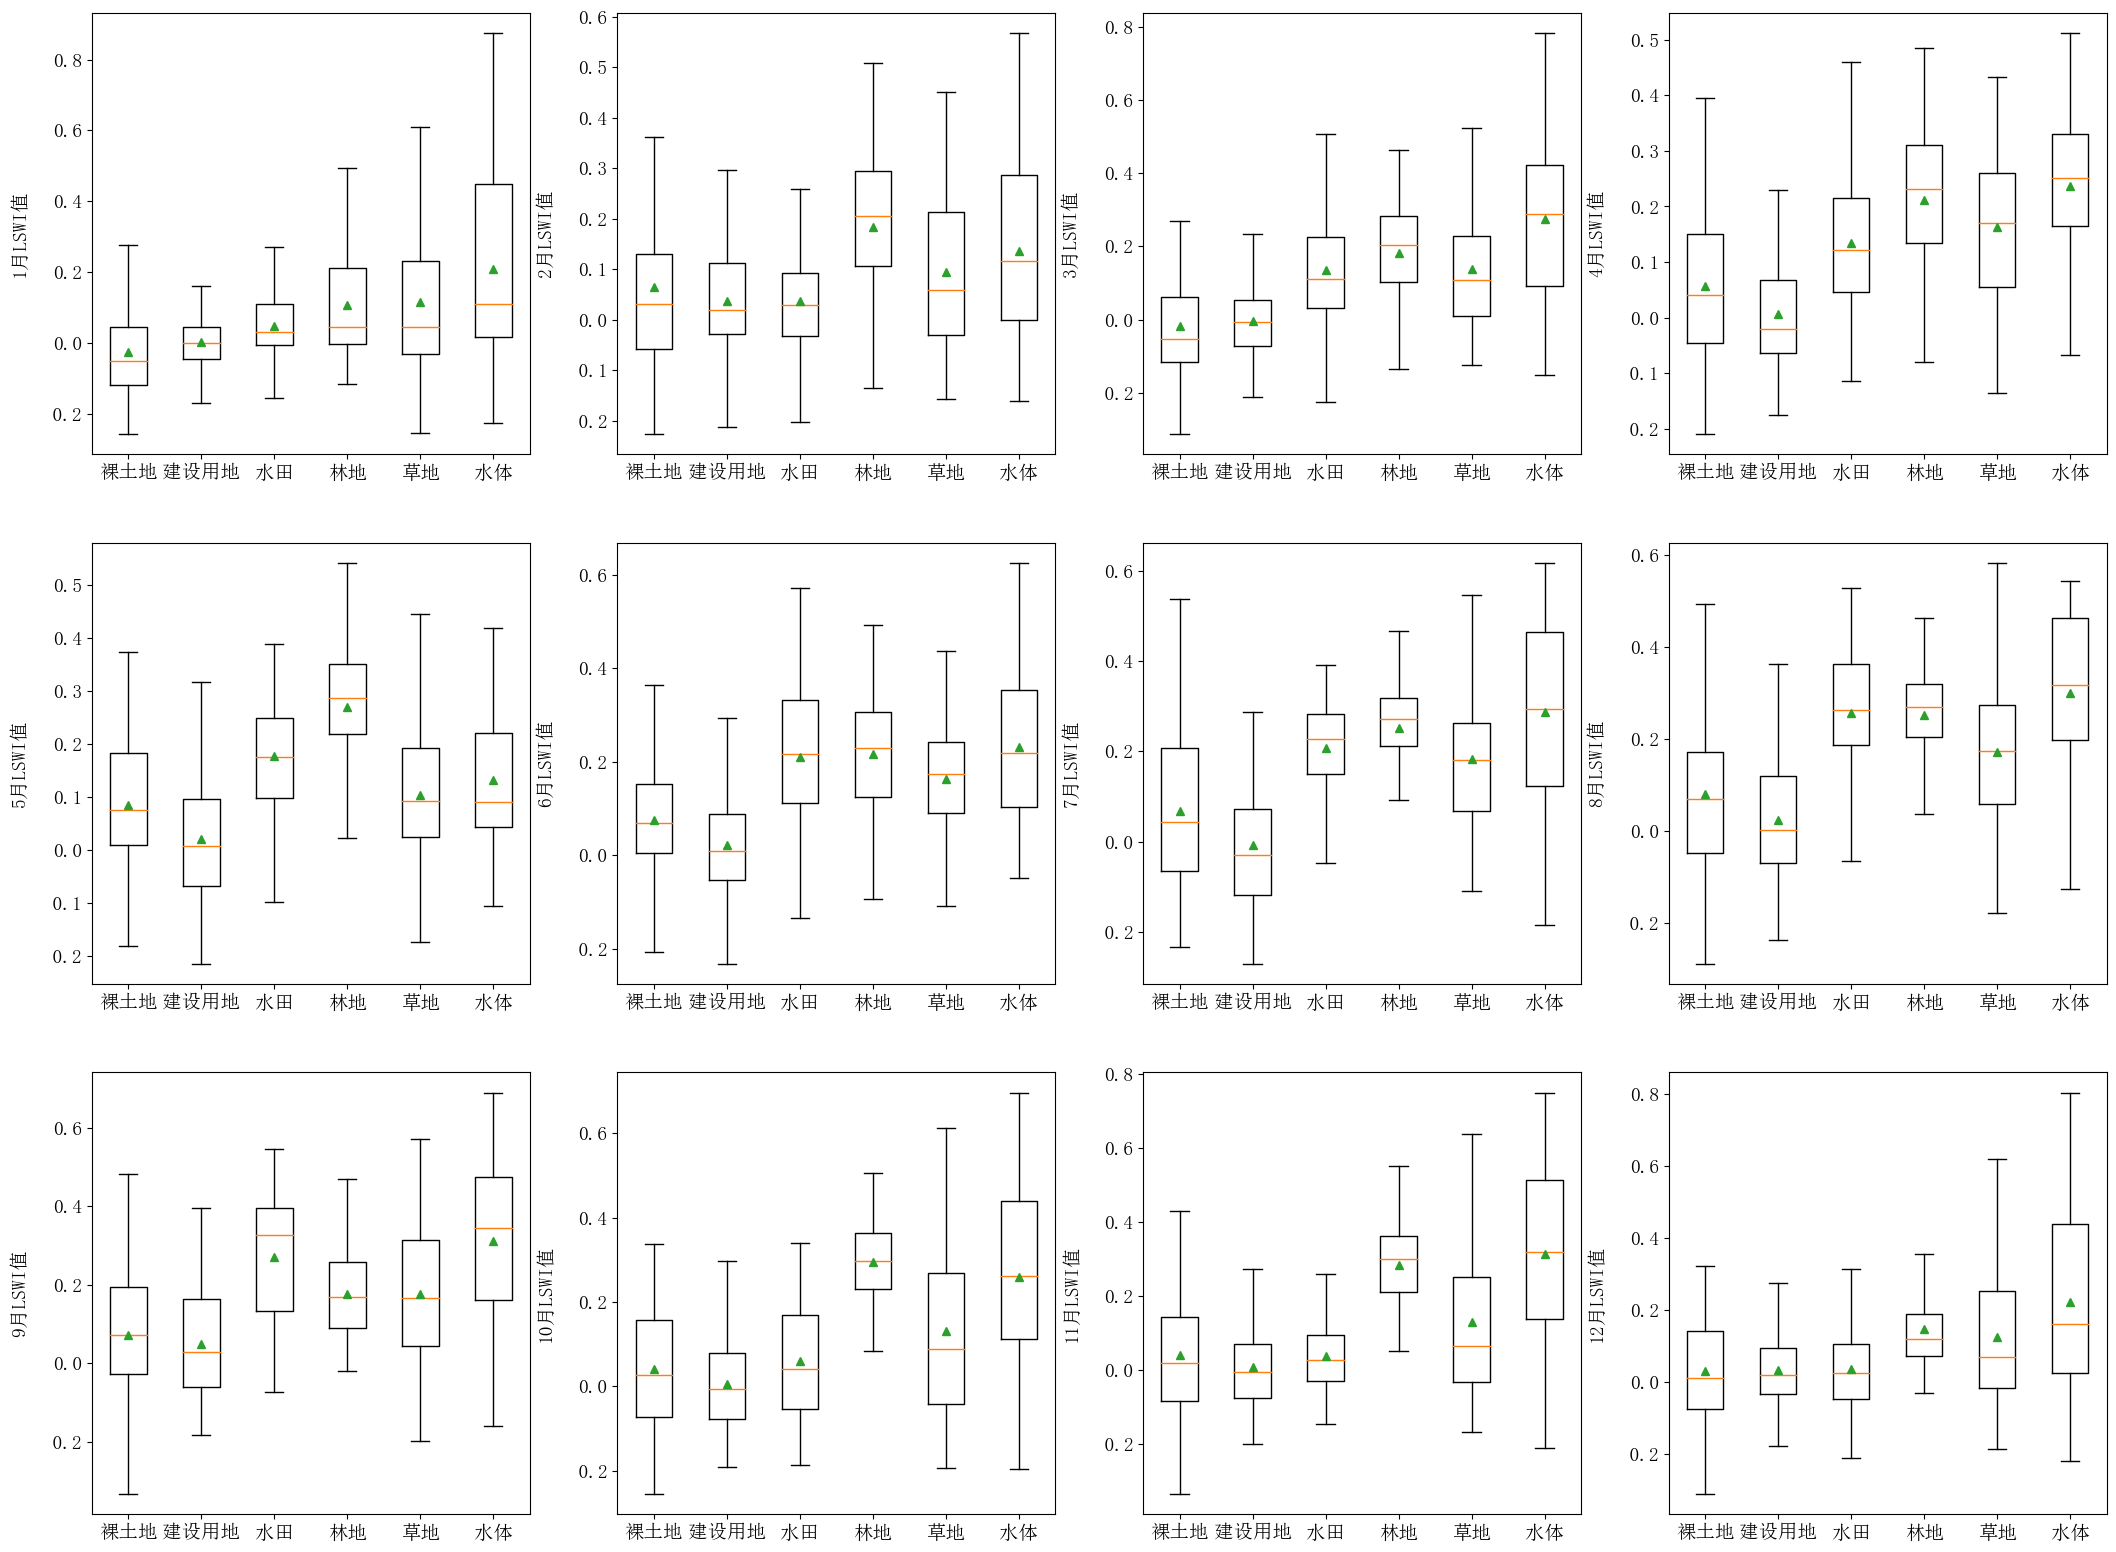

In [103]:
fig, ax = plt.subplots(3, 4, figsize=(4*6.5, 3*6.5))
# ax.plot([i for i in range(365)], lswi_mean.values, '-o', color='blue', lw=1, label='LSWI')
line_type = ['-.', '-s', '-v', '-o', '-+', '-*']
line_color = ['k', 'r', 'y', 'g', 'c', 'b']
lable = ['裸土地', '建设用地', '水田', '林地', '草地', '水体']
a = 0
for i in range(3):
    for j in range(4):
        ax[i][j].set_ylabel(f'{a+1}月LSWI值')
        ax[i][j].boxplot([lswi_df.loc[lswi_df['TDLYDM']==x+1, f'{a}_S2_LSWI'] for x in range(6)], labels=lable, showmeans=True, showfliers=False)
        a += 1
fig.savefig(f'png_data/LSWI_box.png', dpi=600, bbox_inches='tight')

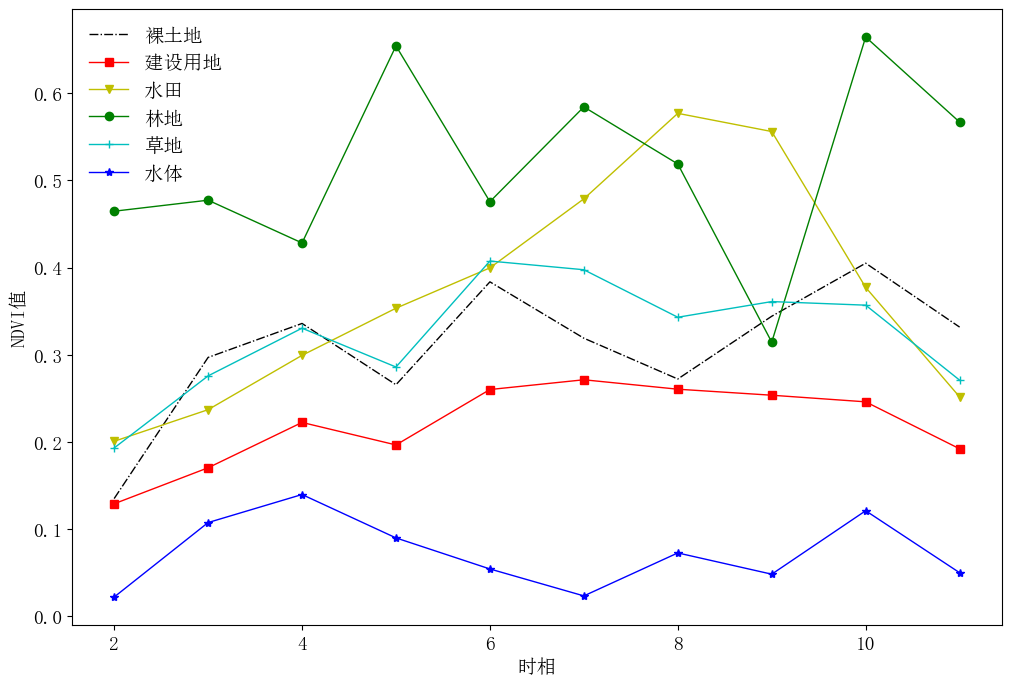

In [97]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlabel('时相')
ax.set_ylabel('NDVI值')
# ax.plot([i for i in range(365)], lswi_mean.values, '-o', color='blue', lw=1, label='LSWI')
line_type = ['-.', '-s', '-v', '-o', '-+', '-*']
line_color = ['k', 'r', 'y', 'g', 'c', 'b']
lable = ['裸土地', '建设用地', '水田', '林地', '草地', '水体']
for i in range(6):
    ax.plot(list(range(2, 12)), ndvi_mean.loc[i+1].values[1:11], line_type[i], color=line_color[i], lw=1, label=lable[i])
ax.legend(loc=2, frameon=False, handlelength=2)
fig.savefig(f'png_data/NDVI_mean.png', dpi=600, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlabel('时相')
ax.set_ylabel('NDVI值')
# ax.plot([i for i in range(365)], lswi_mean.values, '-o', color='blue', lw=1, label='LSWI')
line_type = ['-.', '-s', '-v', '-o', '-+', '-*']
line_color = ['k', 'r', 'y', 'g', 'c', 'b']
lable = ['裸土地', '建设用地', '水田', '林地', '草地', '水体']
for i in range(6):
    ax.plot(list(range(2, 12)), ndvi_mean.loc[i+1].values[1:11], line_type[i], color=line_color[i], lw=1, label=lable[i])
ax.legend(loc=2, frameon=False, handlelength=2)
fig.savefig(f'png_data/NDVI_mean.png', dpi=600, bbox_inches='tight')

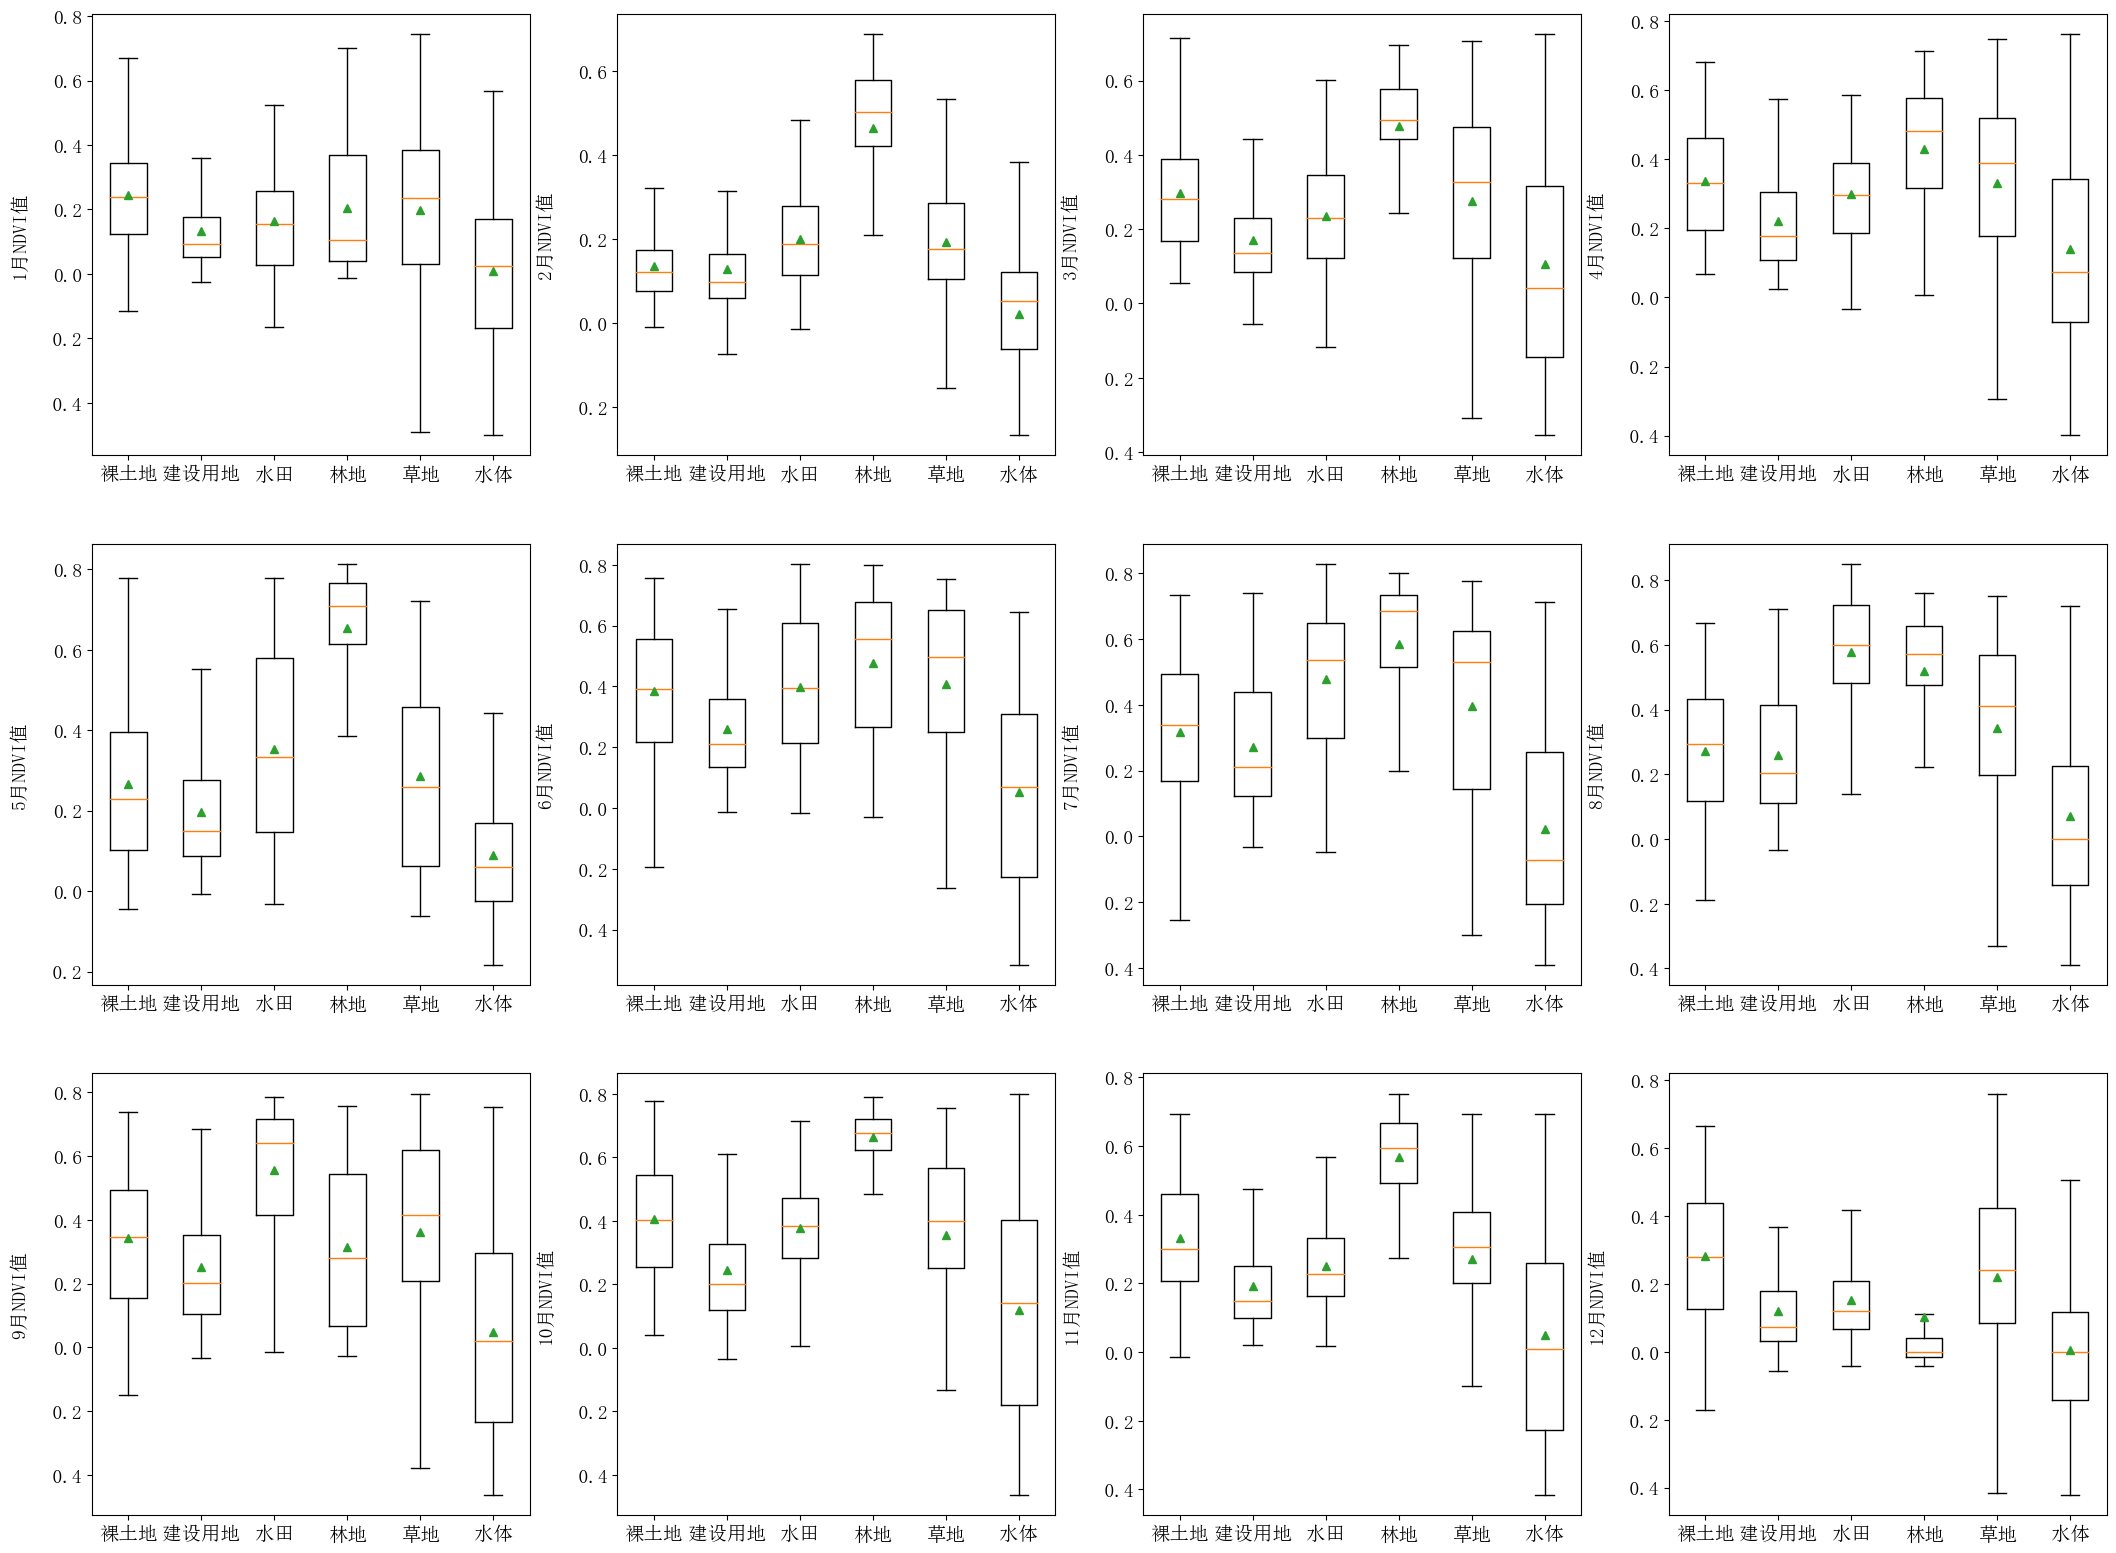

In [102]:
fig, ax = plt.subplots(3, 4, figsize=(4*6.5, 3*6.5))
# ax.plot([i for i in range(365)], lswi_mean.values, '-o', color='blue', lw=1, label='LSWI')
line_type = ['-.', '-s', '-v', '-o', '-+', '-*']
line_color = ['k', 'r', 'y', 'g', 'c', 'b']
lable = ['裸土地', '建设用地', '水田', '林地', '草地', '水体']
a = 0
for i in range(3):
    for j in range(4):
        ax[i][j].set_ylabel(f'{a+1}月NDVI值')
        ax[i][j].boxplot([ndvi_df.loc[ndvi_df['TDLYDM']==x+1, f'{a}_S2_NDVI'] for x in range(6)], labels=lable, showmeans=True, showfliers=False)
        a += 1
# ax.legend(loc=2, frameon=False, handlelength=2)
fig.savefig(f'png_data/NDVI_box.png', dpi=600, bbox_inches='tight')

In [86]:
ndvi_df.loc[, ]

,0_S2_NDVI,10_S2_NDVI,11_S2_NDVI,1_S2_NDVI,2_S2_NDVI,3_S2_NDVI,4_S2_NDVI,5_S2_NDVI,6_S2_NDVI,7_S2_NDVI,8_S2_NDVI,9_S2_NDVI,TDLYDM
0,0.271775,0.281051,0.240283,0.026180,0.280441,0.333588,0.081740,0.534543,0.474191,0.352090,0.375060,0.352459,1
1,0.098802,0.401642,0.005265,0.261719,0.365824,0.380344,0.554097,0.045989,0.596912,0.504469,0.431089,0.536875,1
2,0.253409,0.295931,0.235265,0.191076,0.260235,0.374613,0.033766,0.522472,0.340745,0.335830,0.344401,0.396730,1
3,0.017551,0.066602,-0.026553,0.065181,0.097926,0.115341,0.060851,0.150920,0.100650,0.111675,-0.006104,0.042361,1
4,0.109485,0.202432,0.129369,0.145147,0.125794,0.201331,0.179809,0.294688,0.169151,0.225306,0.208758,0.123926,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.235421,0.499497,0.309054,0.251935,0.055481,0.425551,0.557147,0.629081,0.591984,0.600488,0.471814,0.622257,1
96,0.079675,0.083481,0.065246,0.019544,0.083940,0.114327,0.168476,0.123711,0.054359,0.094490,0.098031,0.081384,1
97,0.417528,0.415357,0.439479,0.068762,0.324090,0.352123,0.305146,0.279292,0.522680,-0.023203,0.021390,0.486213,1
98,0.291408,0.273539,0.346729,0.100227,0.208135,0.290372,0.263608,0.372608,0.378947,0.357300,0.466766,0.544524,1
